In [1]:
import torch
import argparse
import os
import sys
import random

import torch.autograd.profiler as profiler
import wandb

import imaginaire.config
from imaginaire.config import Config
from imaginaire.utils.cudnn import init_cudnn
from imaginaire.utils.dataset import get_train_and_val_dataloader
from imaginaire.utils.distributed import init_dist, is_master, get_world_size
from imaginaire.utils.distributed import master_only_print as print
from imaginaire.utils.gpu_affinity import set_affinity
from imaginaire.utils.misc import slice_tensor
from imaginaire.utils.logging import init_logging, make_logging_dir
from imaginaire.utils.trainer import (get_model_optimizer_and_scheduler,
                                      get_trainer, set_random_seed)

sys.path.append(os.environ.get('SUBMIT_SCRIPTS', '.'))


In [2]:
from collections import namedtuple
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
args = {'config': '/home/woody/i9vl/i9vl106h/configs/projects/spade/kitti/kitt_vanilla_23_7_16_48.yaml',
'logdir': '/home/woody/i9vl/i9vl106h/logs/spade_vanilla_kitti_DEBUG_run',
'checkpoint': '/home/woody/i9vl/i9vl106h/logs/spade_vanilla_kitti_23_7/epoch_00039_iteration_000040000_checkpoint.pt',
'seed': 2,
'randomized_seed': False,
'local_rank': os.getenv('LOCAL_RANK', 0),
'single_gpu': True,
'debug': True,
'use_jit': False,
'profile': False,
'wandb': True,
'wandb_name': 'imaginaire_test',
'wandb_id': 'muzammil',
'resume': 1,

'num_workers': 8,
}

from argparse import Namespace

args = Namespace(**args)

In [4]:
if args.randomized_seed:
    args.seed = random.randint(0, 10000)
set_random_seed(args.seed, by_rank=True)
cfg = Config(args.config)

Using random seed 2


In [43]:
cfg.data.input_types[0].images.normalize = True
cfg.data.input_types[1].label.normalize = False

In [6]:
# Global arguments.
imaginaire.config.DEBUG = args.debug
imaginaire.config.USE_JIT = args.use_jit

In [7]:
cfg.data.num_workers = args.num_workers

In [8]:
cfg.date_uid, cfg.logdir = init_logging(args.config, args.logdir)
make_logging_dir(cfg.logdir)

Make folder /home/woody/i9vl/i9vl106h/logs/spade_vanilla_kitti_DEBUG_run


In [9]:

# Initialize cudnn.
init_cudnn(cfg.cudnn.deterministic, cfg.cudnn.benchmark)


cudnn benchmark: True
cudnn deterministic: False


In [10]:
from imaginaire.datasets.lmdb import \
    IMG_EXTENSIONS, HDR_IMG_EXTENSIONS, LMDBDataset

In [136]:
ds = LMDBDataset(cfg.data.train.roots[0]+"/images")

LMDB file at /home/woody/i9vl/i9vl106h/data/kitti/lmdb/train/images opened.


In [152]:
data_types = ['images', 'label']

In [167]:
lmdbs = {data_type:LMDBDataset(cfg.data.train.roots[0]+"/"+data_type) for data_type in data_types}

LMDB file at /home/woody/i9vl/i9vl106h/data/kitti/lmdb/train/images opened.
LMDB file at /home/woody/i9vl/i9vl106h/data/kitti/lmdb/train/label opened.


In [129]:
with ds.env.begin() as txn:
    curs = txn.cursor()
    keys = list(txn.cursor().iternext(values=False))

In [132]:
keys[0]

b'./0000_0000000000'

In [139]:
img = ds.getitem_by_path(keys[0], "label")

In [142]:
import numpy as np

In [147]:
from imaginaire.utils.data import load_from_lmdb

In [157]:
keys[0].decode('utf-8')

'./0000_0000000000'

In [162]:
keys_input

{'images': ['./0000_0000000000'], 'label': ['./0000_0000000000']}

In [170]:
keys_input  = {data_type:[key.decode('utf-8') for key in keys[:1]] for data_type in data_types}

out = load_from_lmdb(keys_input,
                lmdbs)

In [45]:
train_instance = next(iter(train_data_loader))

detached_image = train_instance['label'].detach().clone().permute(0, 2, 3, 1).cpu().numpy()
detached_label = train_instance['images'].detach().clone().permute(0, 2, 3, 1).cpu().numpy()

/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumenta

In [ ]:
detached_image.max()

: 

In [44]:
batch_size = cfg.data.train.batch_size
total_step = max(cfg.trainer.dis_step, cfg.trainer.gen_step)
cfg.data.train.batch_size *= total_step
train_data_loader, val_data_loader = get_train_and_val_dataloader(cfg, args.seed)


LMDB file at /home/woody/i9vl/i9vl106h/data/kitti/lmdb/train/images opened.
LMDB file at /home/woody/i9vl/i9vl106h/data/kitti/lmdb/train/label opened.
Num datasets: 1
Num sequences: 1
Max sequence length: 4022
LMDB file at /home/woody/i9vl/i9vl106h/data/kitti/lmdb/val/images opened.
LMDB file at /home/woody/i9vl/i9vl106h/data/kitti/lmdb/val/label opened.
Num datasets: 1
Num sequences: 1
Max sequence length: 1005
Train dataset length: 4022
Val dataset length: 1005


In [12]:
net_G, net_D, opt_G, opt_D, sch_G, sch_D = \
        get_model_optimizer_and_scheduler(cfg, seed=args.seed)
    

Using random seed 2
SPADE generator initialization.
Concatenate images:
    ext: png
    normalize: False
    num_channels: 1
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
	Num. of channels in the input image: 1
Concatenate images:
    ext: png
    normalize: False
    num_channels: 1
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
Concatenate label:
    ext: png
    num_channels: 3
    normalize: False
    use_dont_care: False
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
	Num. of channels in the input label: 3
dict_keys(['resize_smallest_side', 'rotate', 'horizontal_flip', 'random_crop_h_w'])
	Crop size: (256, 1000)
	Style code dimensions: 256
	Base filter number: 128
	Convolution kernel size: 3
	Weight norm type: spectral
num_filters: 128
kernel_size: 5
separate_projection: True
activation_norm_type: sync_ba

/home/woody/i9vl/i9vl106h/software/privat/conda/envs/imaginaire/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Done with the SPADE generator initialization.
Multi-resolution patch discriminator initialization.
Concatenate images:
    ext: png
    normalize: False
    num_channels: 1
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
	Num. of channels in the input image: 1
Concatenate images:
    ext: png
    normalize: False
    num_channels: 1
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
Concatenate label:
    ext: png
    num_channels: 3
    normalize: False
    use_dont_care: False
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
	Num. of channels in the input label: 3
	Base filter number: 128
	Number of discriminators: 2
	Number of layers in a discriminator: 5
	Weight norm type: spectral
Done with the Multi-resolution patch discriminator initialization.
Initialize net_G and net_D weights using type: xavier gain: 0.02
Usi

In [13]:
trainer = get_trainer(cfg, net_G, net_D,
                        opt_G, opt_D,
                        sch_G, sch_D,
                        train_data_loader, val_data_loader)

Setup trainer.
Using automatic mixed precision training.
Augmentation policy: 
GAN mode: hinge


/home/woody/i9vl/i9vl106h/software/privat/conda/envs/imaginaire/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/woody/i9vl/i9vl106h/software/privat/conda/envs/imaginaire/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Perceptual loss:
	Mode: vgg19
Loss GAN                  Weight 1.5
Loss Perceptual           Weight 5.0
Loss FeatureMatching      Weight 14.0
Loss GaussianKL           Weight 0.05


In [14]:
args.checkpoint

'/home/woody/i9vl/i9vl106h/logs/spade_vanilla_kitti_23_7/epoch_00039_iteration_000040000_checkpoint.pt'

In [14]:
resumed, current_epoch, current_iteration = trainer.load_checkpoint(cfg, '', args.resume)

No checkpoint found.


In [34]:
train_instance = next(iter(train_data_loader))

detached_image = train_instance['label'].detach().clone().permute(0, 2, 3, 1).cpu().numpy()
detached_label = train_instance['images'].detach().clone().permute(0, 2, 3, 1).cpu().numpy()

/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumenta

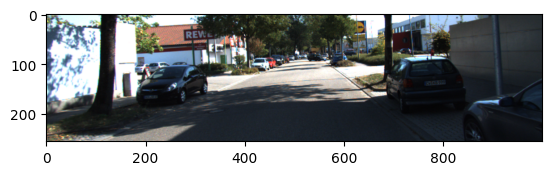

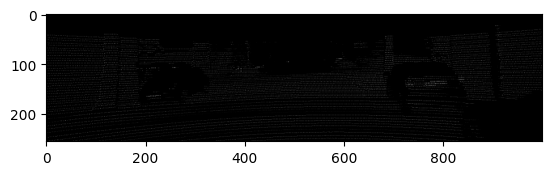

In [46]:
plt.imshow(((detached_image[0])))
plt.show()
plt.imshow(((detached_label[0])), "gray")
plt.show()

In [15]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'SPADE_DEBUG'

In [16]:
if args.wandb_id is not None:
    wandb_id = args.wandb_id
wandb_mode = "disabled" if (args.debug or not args.wandb) else "online"
wandb.init(id=wandb_id,
            project=args.wandb_name,
            config=cfg,
            name=os.path.basename(cfg.logdir),
            resume="allow",
            settings=wandb.Settings(start_method="fork"),
            mode=wandb_mode)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find SPADE_DEBUG.


In [17]:
wandb.config.update({'dataset': cfg.data.name})
wandb.watch(trainer.net_G_module)
wandb.watch(trainer.net_D.module)


[]

In [19]:
for epoch in range(current_epoch, cfg.max_epoch):
    print('Epoch {} ...'.format(epoch))
    if not args.single_gpu:
        train_data_loader.sampler.set_epoch(current_epoch)
    trainer.start_of_epoch(current_epoch)
    for it, data in enumerate(train_data_loader):
        with profiler.profile(enabled=args.profile,
                                use_cuda=True,
                                profile_memory=True,
                                record_shapes=True) as prof:
            data = trainer.start_of_iteration(data, current_iteration)

            for i in range(cfg.trainer.dis_step):
                trainer.dis_update(
                    slice_tensor(data, i * batch_size,
                                    (i + 1) * batch_size))
            for i in range(cfg.trainer.gen_step):
                trainer.gen_update(
                    slice_tensor(data, i * batch_size,
                                    (i + 1) * batch_size))

            current_iteration += 1
            trainer.end_of_iteration(data, current_epoch, current_iteration)
            if current_iteration >= cfg.max_iter:
                print('Done with training!!!')
                break
        if args.profile:
            print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))
            prof.export_chrome_trace(os.path.join(cfg.logdir, "trace.json"))
        try:
            if AutoResume.termination_requested():
                trainer.save_checkpoint(current_epoch, current_iteration)
                AutoResume.request_resume()
                print("Training terminated. Returning")
                break
        except:  # noqa
            pass

    current_epoch += 1
    trainer.end_of_epoch(data, current_epoch, current_iteration)

Epoch 0 ...


/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumenta

Generator overflowed!
Generator overflowed!
Generator overflowed!
Generator overflowed!
Generator overflowed!
Generator overflowed!
Generator overflowed!


KeyboardInterrupt: 

In [47]:
data_ = trainer.start_of_iteration(train_instance, current_iteration)

In [49]:
data_['images'].max()

tensor(0.9686, device='cuda:0')

In [33]:
data.keys()

dict_keys(['images', 'label', 'is_flipped', 'key', 'original_h_w'])

In [62]:
detached_label.max()

-0.9924029

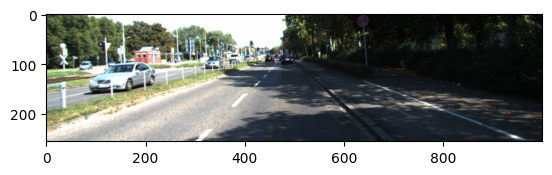

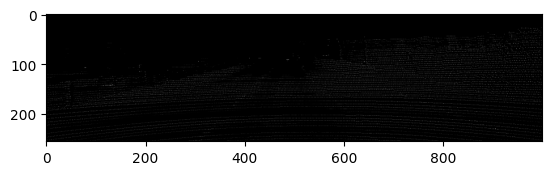

In [61]:
# plot data['label'] and data['images']
detached_image = train_instance['label'].detach().clone().permute(0, 2, 3, 1).cpu().numpy()
detached_label = train_instance['images'].detach().clone().permute(0, 2, 3, 1).cpu().numpy()

plt.imshow(((detached_image[0]+1)/2)*255)
plt.show()
plt.imshow(((detached_label[0]+1)/2)*255, "gray")
plt.show()


In [49]:
net_G_output = net_G(data)

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 39.38 GiB total capacity; 38.71 GiB already allocated; 18.12 MiB free; 38.85 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [48]:
# cuda cache clear
torch.cuda.empty_cache()

In [44]:
net_G_output['fake_images']

tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)

In [2]:
checkpoint_path = 'logs/2024_0722_0109_29_base128_bs4_lmdb/epoch_00015_iteration_000016000_checkpoint.pt'

In [35]:
image_path = "/home/woody/i9vl/i9vl106h/data/processed_for_img2img/train/images//0000_0000000000.png"

In [33]:
import numpy as np
from PIL import Image

In [38]:
array = np.array(Image.open(image_path))

In [18]:
from torchvision import transforms

In [43]:
import lmdb

In [49]:
ls /home/woody/i9vl/i9vl106h/data/kitti/lmdb/val/images/

data.mdb  lock.mdb


In [53]:
root = '/home/woody/i9vl/i9vl106h/data/kitti/lmdb/val/images/'

In [54]:
env = lmdb.open(root, max_readers=126, readonly=True, lock=False,
                             readahead=False, meminit=False)

In [56]:
with env.begin() as txn:
    length = txn.stat()['entries']

In [62]:
with env.begin() as txn:
  keys = list(txn.cursor().iternext(values=False))

In [64]:
idx = 1

In [66]:
with env.begin(write=False) as txn:
    buf = txn.get(keys[idx])

In [68]:
import cv2

In [69]:
img = cv2.imdecode(np.fromstring(buf, dtype=np.uint8), -1)

/tmp/ipykernel_55423/225762566.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = cv2.imdecode(np.fromstring(buf, dtype=np.uint8), -1)


In [75]:
array_n = transforms.Normalize(mean=[128], std=[128])(torch.Tensor(array).unsqueeze(0))

In [76]:
print(array_n.shape, array_n.min(), array_n.max())

torch.Size([1, 286, 1242, 3]) tensor(-0.9688) tensor(0.9922)


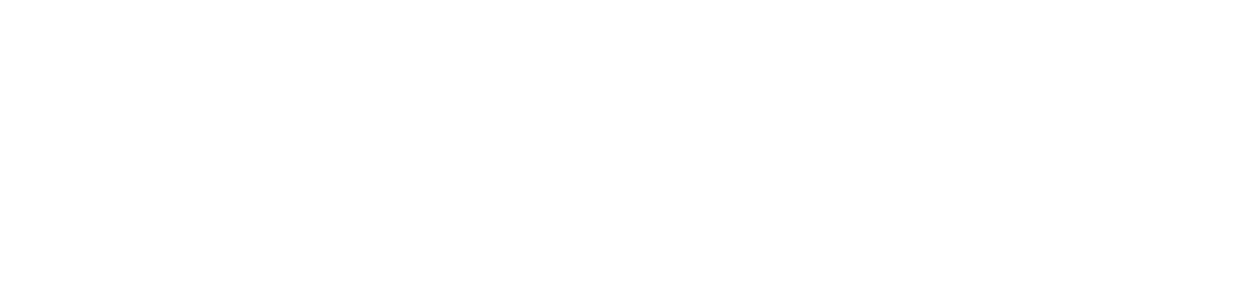

In [42]:
Image.fromarray((array > 0).astype(np.uint8)*255)

In [3]:
checkpoint = torch.load(
            checkpoint_path, map_location=lambda storage, loc: storage)

In [6]:
net_G = checkpoint['net_G']

In [7]:
net_G.key

OrderedDict([('module.num_updates_tracked', tensor(16000)),
             ('module.module.spade_generator.fc_0.layers.conv.bias',
              tensor([ 1.7434e-03,  2.9196e-03,  3.1397e-03,  4.6093e-03, -3.7755e-03,
                      -1.7486e-03, -2.3133e-03,  3.2114e-03, -4.0244e-03, -1.2832e-05,
                       7.4993e-04,  3.2427e-03, -3.3497e-03,  1.8769e-03,  4.2770e-03,
                      -1.5320e-03,  2.8188e-03,  1.3811e-03, -3.4890e-03,  1.2832e-03,
                       1.6514e-03, -2.8024e-03, -1.2450e-03,  4.4597e-03, -1.1261e-03,
                       3.8412e-03, -4.7017e-03, -4.1859e-03,  1.7197e-03, -6.4119e-03,
                       2.3469e-04,  5.4906e-03,  1.8742e-03, -4.7533e-03, -1.8297e-03,
                       2.5578e-04, -4.7423e-03, -3.2485e-03,  3.2119e-03,  3.0206e-03,
                      -4.9623e-04, -2.0519e-03,  2.8074e-03,  3.1196e-03,  2.8490e-03,
                      -2.7230e-03, -2.9735e-03,  5.6498e-03, -5.1067e-03, -1.7468e-03,
 

In [1]:
import argparse
import os
import sys
import random

import torch.autograd.profiler as profiler
import wandb

import imaginaire.config
from imaginaire.config import Config
from imaginaire.utils.cudnn import init_cudnn
from imaginaire.utils.dataset import get_train_and_val_dataloader
from imaginaire.utils.distributed import init_dist, is_master, get_world_size
from imaginaire.utils.distributed import master_only_print as print
# from imaginaire.utils.gpu_affinity import set_affinity
from imaginaire.utils.misc import slice_tensor
from imaginaire.utils.logging import init_logging, make_logging_dir
from imaginaire.utils.trainer import (get_model_optimizer_and_scheduler,
                                      get_trainer, set_random_seed)

sys.path.append(os.environ.get('SUBMIT_SCRIPTS', '.'))

In [2]:
config = "/home/hpc/i9vl/i9vl106h/imaginaire/configs/projects/spade/kitti/base128_bs4_lmdb.yaml"

In [3]:
def parse_args():
    parser = argparse.ArgumentParser(description='Training')
    parser.add_argument('--config',
                        help='Path to the training config file.', required=True)
    parser.add_argument('--logdir', help='Dir for saving logs and models.')
    parser.add_argument('--checkpoint', default='', help='Checkpoint path.')
    parser.add_argument('--seed', type=int, default=2, help='Random seed.')
    parser.add_argument('--randomized_seed', action='store_true', help='Use a random seed between 0-10000.')
    parser.add_argument('--local_rank', type=int, default=os.getenv('LOCAL_RANK', 0))
    parser.add_argument('--single_gpu', action='store_true')
    parser.add_argument('--debug', action='store_true')
    parser.add_argument('--use_jit', action='store_true')
    parser.add_argument('--profile', action='store_true')
    parser.add_argument('--wandb', action='store_true')
    parser.add_argument('--wandb_name', default='default', type=str)
    parser.add_argument('--wandb_id', type=str)
    parser.add_argument('--resume', type=int)
    parser.add_argument('--num_workers', type=int)
    args = parser.parse_args()
    return args


In [4]:
cfg = Config(config)

In [5]:
train_data_loader, val_data_loader = get_train_and_val_dataloader(cfg, 42)

LMDB file at /home/woody/i9vl/i9vl106h/data/kitti/lmdb/train/images opened.
LMDB file at /home/woody/i9vl/i9vl106h/data/kitti/lmdb/train/label opened.
Num datasets: 1
Num sequences: 1
Max sequence length: 4022
LMDB file at /home/woody/i9vl/i9vl106h/data/kitti/lmdb/val/images opened.
LMDB file at /home/woody/i9vl/i9vl106h/data/kitti/lmdb/val/label opened.
Num datasets: 1
Num sequences: 1
Max sequence length: 1005
Train dataset length: 4022
Val dataset length: 1005


In [6]:
from matplotlib import pyplot as plt

In [13]:
net_G, net_D, opt_G, opt_D, sch_G, sch_D = \
        get_model_optimizer_and_scheduler(cfg, seed=42)

Using random seed 42
SPADE generator initialization.
Concatenate images:
    ext: png
    num_channels: 1
    normalize: False
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
	Num. of channels in the input image: 1
Concatenate images:
    ext: png
    num_channels: 1
    normalize: False
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
Concatenate label:
    ext: png
    num_channels: 3
    normalize: True
    use_dont_care: False
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
	Num. of channels in the input label: 3
dict_keys(['resize_smallest_side', 'rotate', 'random_scale_limit', 'horizontal_flip', 'random_crop_h_w'])
	Crop size: (256, 1000)
	Style code dimensions: 256
	Base filter number: 128
	Convolution kernel size: 3
	Weight norm type: spectral
num_filters: 128
kernel_size: 5
separate_projection: True
activat

/home/woody/i9vl/i9vl106h/software/privat/conda/envs/imaginaire/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Done with the SPADE generator initialization.
Multi-resolution patch discriminator initialization.
Concatenate images:
    ext: png
    num_channels: 1
    normalize: False
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
	Num. of channels in the input image: 1
Concatenate images:
    ext: png
    num_channels: 1
    normalize: False
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
Concatenate label:
    ext: png
    num_channels: 3
    normalize: True
    use_dont_care: False
    is_mask: False
    pre_aug_ops: None
    post_aug_ops: None
    computed_on_the_fly: False for input.
	Num. of channels in the input label: 3
	Base filter number: 128
	Number of discriminators: 2
	Number of layers in a discriminator: 5
	Weight norm type: spectral
Done with the Multi-resolution patch discriminator initialization.
Initialize net_G and net_D weights using type: xavier gain: 0.02
Usin

In [14]:
trainer = get_trainer(cfg, net_G, net_D,
                          opt_G, opt_D,
                          sch_G, sch_D,
                          train_data_loader, val_data_loader)
    

Setup trainer.
Using automatic mixed precision training.
Augmentation policy: 
GAN mode: hinge


/home/woody/i9vl/i9vl106h/software/privat/conda/envs/imaginaire/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/woody/i9vl/i9vl106h/software/privat/conda/envs/imaginaire/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Perceptual loss:
	Mode: vgg19
Loss GAN                  Weight 1.0
Loss Perceptual           Weight 10.0
Loss FeatureMatching      Weight 10.0
Loss GaussianKL           Weight 0.05


In [6]:
batch = next(iter(train_data_loader))

/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumenta

In [11]:
current_epoch = 0
current_iteration = 0
batch_size = 2

In [15]:
for epoch in range(current_epoch, cfg.max_epoch):
    print('Epoch {} ...'.format(epoch))
    trainer.start_of_epoch(current_epoch)
    for it, data in enumerate(train_data_loader):
        with profiler.profile(enabled=False,
                                use_cuda=True,
                                profile_memory=True,
                                record_shapes=True) as prof:
            data = trainer.start_of_iteration(data, current_iteration)

            for i in range(cfg.trainer.dis_step):
                trainer.dis_update(
                    slice_tensor(data, i * batch_size,
                                    (i + 1) * batch_size))
            for i in range(cfg.trainer.gen_step):
                trainer.gen_update(
                    slice_tensor(data, i * batch_size,
                                    (i + 1) * batch_size))

            current_iteration += 1
            trainer.end_of_iteration(data, current_epoch, current_iteration)

Epoch 0 ...


/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
/home/hpc/i9vl/i9vl106h/.local/lib/python3.8/site-packages/albumenta

Generator overflowed!
Generator overflowed!
Generator overflowed!
Generator overflowed!
Generator overflowed!
Generator overflowed!
Generator overflowed!
Generator overflowed!
Discriminator overflowed!
Discriminator overflowed!
Discriminator overflowed!
Discriminator overflowed!
Discriminator overflowed!
Discriminator overflowed!
Discriminator overflowed!
Iteration: 100, average iter time: 0.620528.


Exception: Log writer not set.